This is an introduction to **time series forecasting using TensorFlow**. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections:

 * Forecast for a single timestep:
    * A single feature.
    * All features.
 * Forecast multiple steps:
    * Single-shot: Make the predictions all at once.
    * Autoregressive: Make one prediction at a time and feed the output back to the model.

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

**Weather dataset**

This work uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/)

This dataset contains 14 different features such as *air temperature*, *atmospheric pressure*, and *humidity*. These were collected every 10 minutes, beginning in 2003. For efficiency, we will use only the data collected between 2009 and 2016.

In [2]:
zip_path = tf.keras.utils.get_file(
           origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
           fname='jena_climate_2009_2016.csv.zip', extract=True)
csv_path, _ = os.path.splitext(zip_path)

We will just deal here with **hourly predictions**, so let's start by sub-sampling the data from 10 minute intervals to 1h

In [3]:
df = pd.read_csv(csv_path)

#Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Let's plot the evolution of a few features over time.

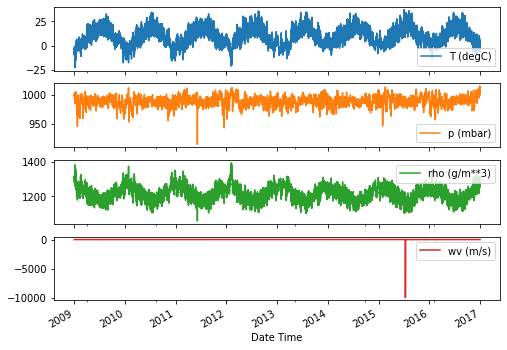

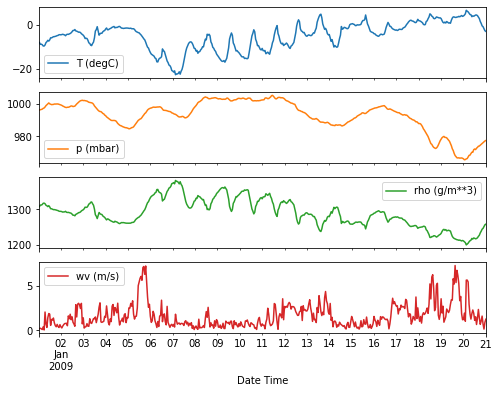

In [4]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)', 'wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Next let's **inspect data's stastistics and perform some cleanup**

Inspect each row's stastistics and make sure everything is approximatly normal.

In [5]:
def description(df):
    """
    Return basic statistics.
    """
    summary = pd.DataFrame(df.dtypes, columns=['dtypes']).reset_index()
    summary = summary.rename(columns={'index':'name'})
    summary['Missing'] = df.isnull().sum().values
    #summary['sample'] = summary.name.apply(lambda x: data[x].sample(frac=1.).values.tolist()[0])
    summary['nunique'] = df.nunique().values
    summary['unique'] = df.apply(lambda x: list(x.unique()), axis=0).reset_index()[0]
    return summary

description(df)

,name,dtypes,Missing,nunique,unique
0,p (mbar),float64,0,4886,"[996.5, 996.62, 996.84, 996.99, 997.46, 997.71..."
1,T (degC),float64,0,4673,"[-8.05, -8.88, -8.81, -9.05, -9.63, -9.67, -9...."
2,Tpot (K),float64,0,4752,"[265.38, 264.54, 264.59, 264.34, 263.72, 263.6..."
3,Tdew (degC),float64,0,3701,"[-8.78, -9.77, -9.66, -10.02, -10.65, -10.62, ..."
4,rh (%),float64,0,4194,"[94.4, 93.2, 93.5, 92.6, 92.2, 92.7, 92.9, 92...."
5,VPmax (mbar),float64,0,3326,"[3.33, 3.12, 3.13, 3.07, 2.94, 2.93, 3.04, 3.3..."
6,VPact (mbar),float64,0,2205,"[3.14, 2.9, 2.93, 2.85, 2.71, 2.83, 3.07, 3.13..."
7,VPdef (mbar),float64,0,2730,"[0.19, 0.21, 0.2, 0.23, 0.22, 0.24, 0.3, 0.33,..."
8,sh (g/kg),float64,0,1443,"[1.96, 1.81, 1.83, 1.78, 1.69, 1.76, 1.92, 1.9..."
9,H2OC (mmol/mol),float64,0,2237,"[3.15, 2.91, 2.94, 2.85, 2.71, 2.72, 2.83, 3.0..."


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


One thing that should stand out is the $min$ value of the **wind velocity**, $wv (m/s)$ and $max. wv (m/s)$ columns. This $-9999$ is likely **erroneous**. There's a separate wind direction column, so the velocity should be >=0. We would replace it with zeros.

In [7]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

#This is an inplace edits which will reflect in the DataFrame.
df['wv (m/s)'].min(), df['max. wv (m/s)'].min()

(0.0, 0.0)

**Feature engineering**

Before diving in to build a model it's important to understand the data, and be sure that you're passing the model appropriately *formatted data*.

The last column of the data, Wind **wd (deg)**, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Text(0, 0.5, 'Wind Velocity [m/s]')

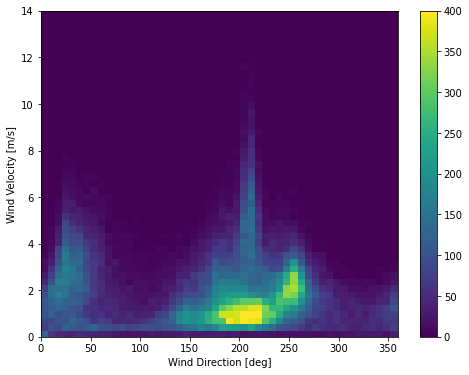

In [8]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

This will be easier for the model to interpret if you convert the wind direction and velocity columns to a **wind vector** where each value can be interpret as a **distance**.

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

#Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

#Calculate the Wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

#Calculate max wind x and y coponents.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

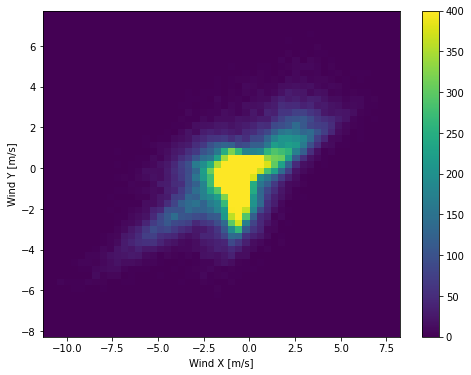

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

(-19.64147299215435,
 11.913133039539135,
 -14.88336704201272,
 14.302308062832465)

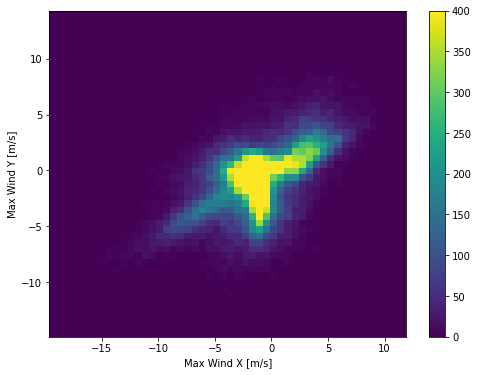

In [11]:
plt.hist2d(df['max Wx'], df['max Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Max Wind X [m/s]')
plt.ylabel('Max Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

The distribution of **wind vectors** is much simpler for the model to correctly interpret

Similarly the **Date Time** column is very useful, but not in this string form. Let's start by converting it to seconds.

In [12]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Note that Time can be seen as the feature containing the sequantial information abouth the data.
Similary to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity.
They are many way to deal with **periodicity**.

A simple approach to convert it to a usable signal is to use $sin$ and $cos$ to convert the time to clear **Time of day** and **Time of year** signals.

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0, 0.5, 'Time of day signal')

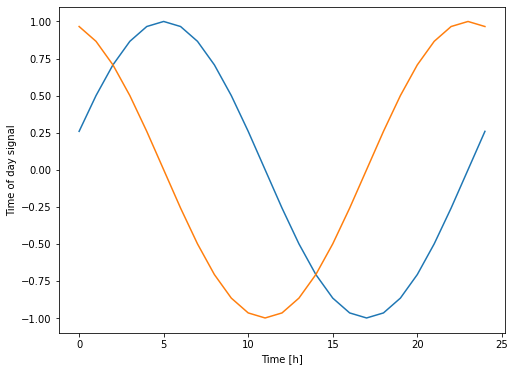

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.ylabel('Time of day signal')

This gives the model access to the most important frequency features. In this caswe knew ahead of time which frequencies were important.

To determine which frequencies are important we can use an **fft**. To check our previous assumptions, let study the **tf.signal.rfft** of the **Temperature** over time.

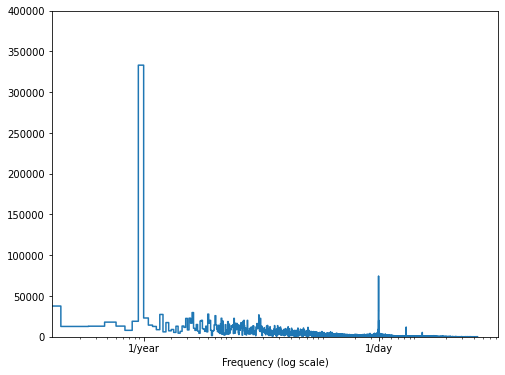

In [15]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hour_per_year = 24*365.2524
year_per_dataset = n_samples_h/(hour_per_year)

f_per_year = f_per_dataset/year_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

We can note the obvious peaks at frequencies near **1/year** and **1/day**. **Temperature** here has clearly a year and day **periodicity**

Next let's split the data we'll use a **(70%, 20%, 10%)** split for the training, validation, and test sets. Note the data is **not being randomly shuffled** before splitting, the chronological order is kept. This is for two reasons.

 * It ensures that chopping the data into windows of consecutive samples is still possible.
 * It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

**Normalize the data**

It is important to **scale features** before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

*The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.*

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using **moving averages**. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity we'll use a **simple average.**

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

**Now peek at the distribution of the features.**

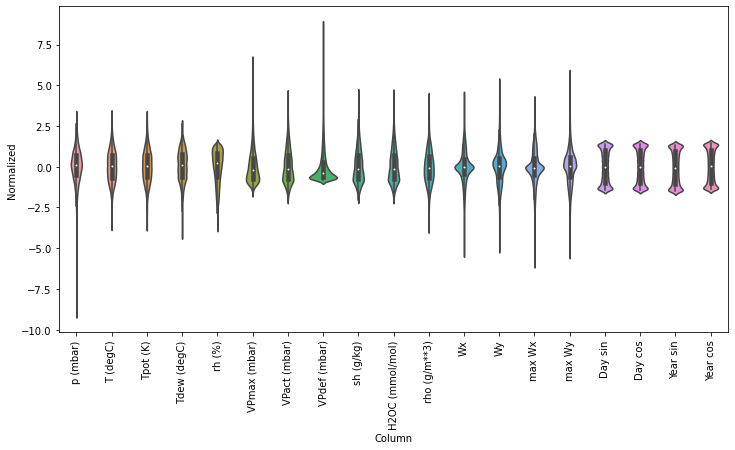

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Some features do have long tails, but there are no obvious errors like the **-9999** wind velocity value.

**Data windowing**

the models will make a set of predictions based on a consecutive samples from data.
The main features input window are:
 * The width (number of time steps) of the input and label windows
 * The time offset between them.
 * Which features are used as inputs, labels, or both.

We will build a variety of models (including Linear, DNN, CNN, and RNN models) and uses them for both:
 * Single-ouput and multi-output predictions.
 * Single-time-step and multiple-time-step predictions.
 
In this section we will be implementing the **data windowing** so that it can be reused for all of those models.
Depending on the task and the type of model we may want to generate a variety of *data window*:
1. For example, to make a single prediction 24h into the future, given 24h of history we might define a window like:
![One prediction 24h into the future.](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/structured_data/images/raw_window_24h.png)
2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:
![One prediction 1h into the future.](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/structured_data/images/raw_window_1h.png)

Next we'll define a **window generator class**. Which can:
   1. Handle the indexes and offsets as shown in the diagrams above.
   2. Split windows of features into a **(features, labels)** pairs.
   3. Plot the content of the resulting windows.
   4. Efficiently generate batches of these windows from the training, evaluation and test data, using **tf.data.Dataset**.


**Indexes and offsets:**

Let's start by creating a **WindowGenerator** class. The **__init__** method includes all the necessary logic for the input and the label indices.

It also takes the train, eval and test dataframes as input. These will be converted to **tf.data.Dataset** of windows later.

In [19]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        #Store raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        #Work out the label indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name (s): {self.label_columns}'])

Here is the code to create the 2 windows describe in the diagrams at the start of this section:

In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name (s): ['T (degC)']

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name (s): ['T (degC)']

Now Let's perform the **Split**

Given a list of **consecutive inputs**, the **split_window** method will convert them to a **window of inputs** and a **window of labels.**
An example  for **w2**, above, will be split like this:
![split window](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/structured_data/images/split_window.png)

This diagram doesn't show the **features** axis of the data, but this **split_window** function also handles the **label_columns** so it can be used for both the single output and multi-output examples. 

In [22]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    
    #Slicing doesn't preserve static shape information, so set the shapes
    #Manually. This way the tf.data.Datasets are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [23]:
#Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                          np.array(train_df[100:100+w2.total_window_size]),
                          np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shape are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shape are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


Typically data in Tensorflow is packed into arrays where the outermost index is across examples( the batch dimension). The middle indices are the time or space(width, height) dimension(s). The innermost indices aret the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each timestep. It split them into a batch of 6 timestep, 19 feature inputs ad a 1-timestep 1 -feature label. The label has only one feature beacause the **WindowGenerator** was initialized with **label_columns=['T (degC)']. 
Initially we'll build models that predict single output labels.

The following plot method allows a simple visiualization of the split window:

In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                       marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
            
        if n == 0:
            plt.legend()
    plt.xlabel('Time [h]')
        
WindowGenerator.plot = plot

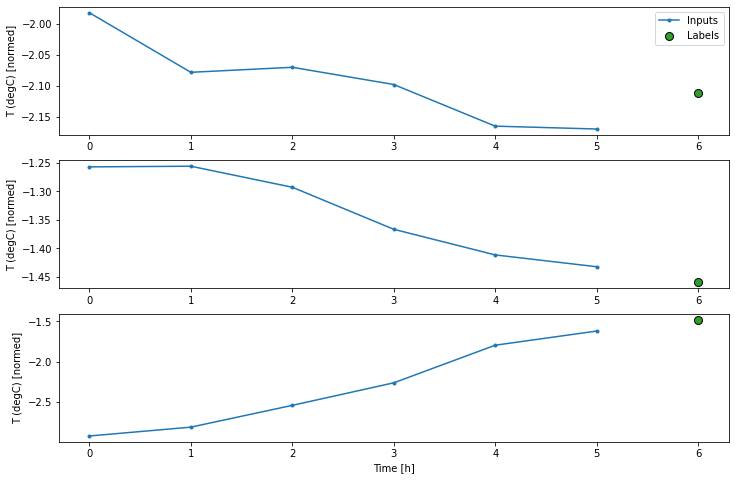

In [26]:
w2.plot()

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to.

We can plot the other columns, but the example window **w2** configuration only has labels for the **T (degC)** column.

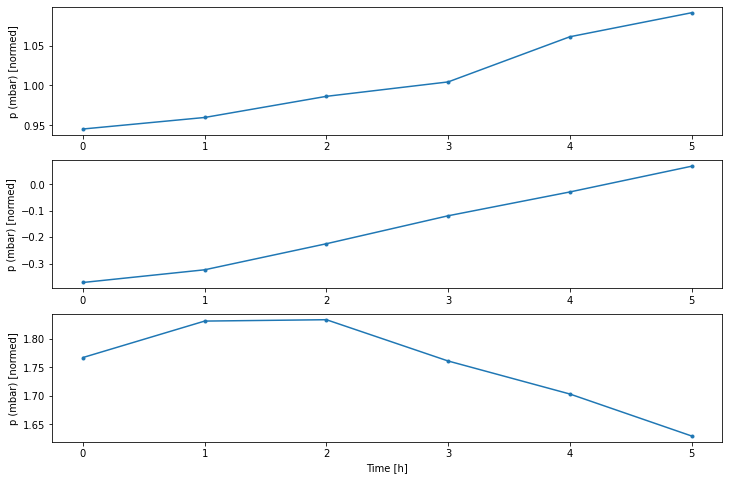

In [27]:
w2.plot(plot_col='p (mbar)')

**Create tf.data.Datasets**

Finally the **make_dataset** method will take a time series **DataFrame** and convert it to a *tf.data.Dataset* of **(input_window, label_window)** pairs using the **preprocessing.timeseries_dataset_from_array** function:

In [28]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data,
                                                             targets=None,
                                                             sequence_length=self.total_window_size,
                                                             sequence_stride=1,
                                                             shuffle=True,
                                                             batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

The **WindowGenerator** object holds *training*, *validation* and *test data*. Add properties for accessing them as *tf.data.Datasets* using the above *make_dataset* method. Also add a standard example batch for easy access and plotting.

In [29]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache and example batch of `inputs labels` for plotting"""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found so get one from the .train dataset
        result = next(iter(self.train))
        # And cache i for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the **WindowGenerator** object gives access to the *tf.data.Dataset* objects, so we can easily iterate over the data.

The **Dataset.element_spec** property tells us the structure, **dtypes** and shapes of the dataset elements.

In [30]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [31]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


Now Let's implement a **single step model:**
The simplest model we can build on this type of problem ione that predicts a single feature's value, 1 timestep(1h) in the future based only on the current conditions.

*So we Let's start by building models to predict the **T (degC)** value 1h into the future.*
![Single step model](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/structured_data/images/narrow_window.png)

Let's first configure a **WindowGenerator** object to produce these single-step **(input, label)** pairs. This object create a **tf.data.datasets** from training, validation and test sets, allowing to esily iterat over batches of data.

In [32]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name (s): ['T (degC)']

In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


**Baseline**

Before building a trainable model it would be good to have a **performance baseline** as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature.

So start with a model that just returns the current temperature as the prediction, predicting **"No change"**. This is a reasonable baseline since temperature changes slowly. *Of course, this baseline will work less well if you make a prediction further in the future.*
![Baseline](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/structured_data/images/baseline.png)

In [34]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [35]:
#Let's instanciate and evaluate this model:

baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0790


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The **WindowGenerator** has a plot method, but the plots won't be very interesting with only a single sample. So, create a **wider WindowGenerator** that generates windows 24h of consecutive inputs and labels at a time.

The **wide_window** doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the time axis acts like the batch axis: Each prediction is made independently with no interaction between time steps.

This expanded window can be passed directly to the same baseline model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:
![wide window](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/tutorials/structured_data/images/wide_window.png)

In [36]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['T (degC)'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name (s): ['T (degC)']

In [37]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


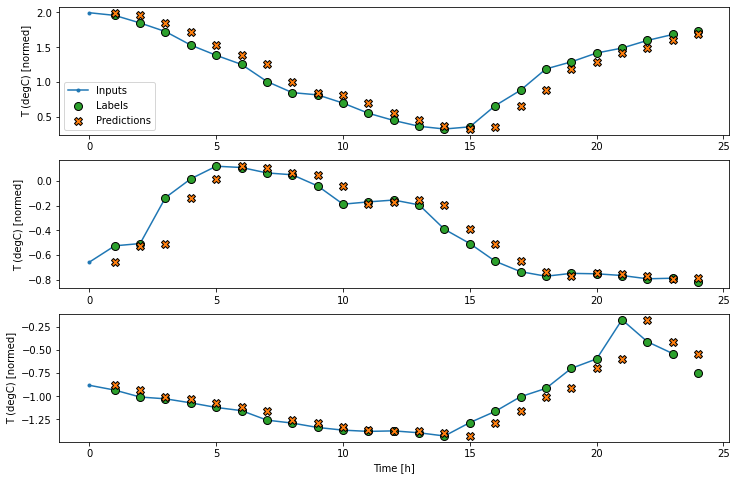

In [40]:
wide_window.plot(baseline)